In [50]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, SpatialDropout1D, Input
from keras.layers import GlobalMaxPooling1D, GRU, SimpleRNN
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from pymongo import MongoClient
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import pymysql
import seaborn as sns
import datetime
# CNN
from keras.layers.convolutional import Conv1D
# RNN
from keras.layers.recurrent import LSTM

In [51]:
maxlen = 400
max_words= 225
n_epochs = 4
n_df_size = 30000
model_name_for_sql = 'selfnn'
tosql = False
agg = [
    {
        '$sample': {
            'size': n_df_size
        }
    }
]

In [52]:

client = MongoClient("localhost:27017")
db=client.indv
result=db.labeled.aggregate(agg)
source=list(result)
df=pd.DataFrame(source)
df.head()

,_id,level_0,index,Unnamed: 0,Review,Label,Total_Words
0,5ff264035173b66dc8621487,188214,188214,188214,Room decor is very outdated,Negative,5
1,5ff263fc5173b66dc85d4d8e,84631,84631,84631,Temperature Was freezing in restaurant,Negative,5
2,5ff263f35173b66dc857f400,313027,313027,313027,The hotel is quite far from downtown and metr...,Negative,66
3,5ff263f65173b66dc859cc3a,2454,2454,2454,The room was far too small for two people it ...,Negative,20
4,5ff263fe5173b66dc85f7e80,290926,290926,290926,Expensive for what it is,Negative,5


In [53]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(df['Review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [54]:
Y = df['Label']

In [55]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [56]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [57]:
max_words = 1000
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
X_train = tok.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen=max_len)

X_test = tok.texts_to_sequences(X_test)
X_test = pad_sequences(X_test,maxlen=max_len)

vocab_size = len(tok.word_index) + 1

In [58]:
# def RNN():
#     inputs = Input(name='inputs',shape=[max_len])
#     layer = Embedding(max_words,50,input_length=max_len)(inputs)
#     layer = LSTM(64)(layer)
#     layer = Dense(256,name='FC1')(layer)
#     layer = Activation('relu')(layer)
#     layer = Dropout(0.5)(layer)
#     layer = Dense(1,name='out_layer')(layer)
#     layer = Activation('sigmoid')(layer)
#     model = Model(inputs=inputs,outputs=layer)
#     return model

In [59]:
model = Sequential()
model.add(Embedding(vocab_size,32,input_length=max_len))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 150, 32)           448736    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 531,297
Trainable params: 531,297
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.fit(X_train,Y_train,batch_size=128,epochs=n_epochs,validation_split=0.2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])

Epoch 1/4
160/160 [==============================] - 34s 200ms/step - loss: 0.6692 - accuracy: 0.7019 - val_loss: 0.2330 - val_accuracy: 0.9200
Epoch 2/4
160/160 [==============================] - 29s 184ms/step - loss: 0.2213 - accuracy: 0.9224 - val_loss: 0.2070 - val_accuracy: 0.9300
Epoch 3/4
160/160 [==============================] - 30s 188ms/step - loss: 0.1699 - accuracy: 0.9422 - val_loss: 0.1881 - val_accuracy: 0.9363
Epoch 4/4
141/141 [==============================] - 4s 27ms/step - loss: 0.2241 - accuracy: 0.9180
Test Score: 0.2241087406873703
Test Accuracy: 0.9179999828338623


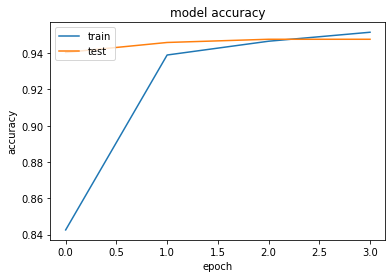

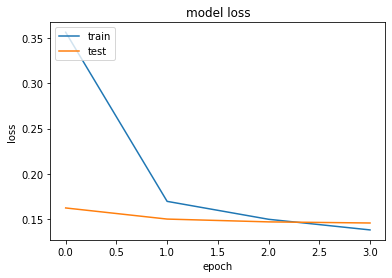

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
pred = 

In [62]:
# # Convelutional ///////////

# # create the model
# model = Sequential()
# model.add(Embedding(vocab_size, 32, input_length=maxlen))
#     #  text is 1 dimensional, so Conv1D
#     #  the kernel in this case is a vector of length 5, not a 2 dimensional matrix
# model.add(Conv1D(128, 5, activation='relu'))
#     #  the pooling layer in this case is also 1 dimensional
# model.add(GlobalMaxPooling1D())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [63]:
# # history=model.fit(X_train, Y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
# # # Final evaluation of the model
# # scores = model.evaluate(X_test, Y_test, verbose=1)
# print("Test Score:", scores[0])
# print("Test Accuracy:", scores[1])

Test Score: 0.18353113532066345
Test Accuracy: 0.9313333630561829


In [64]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc = 'upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc = 'upper left')
# plt.show()